# Import Required Libraries

In [1]:
import zipfile
import os
import yaml
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load and Parse the YAML Files

In [2]:
zip_file_path = "C:/Users/gurob/Downloads/tests.zip"  # Path to the ZIP file
extraction_dir = "C:/Users/gurob/Desktop/tests.zip"    # Path to extract files

# Create the extraction directory if it does not exist
os.makedirs(extraction_dir, exist_ok=True)

# Extract ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print("All Files extracted successfully to:", extraction_dir)

# YAML Loader
def load_yaml_files_optimized(path):
    yaml_files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.yaml')]
    data = []

    for file in yaml_files:
        with open(file, 'r', encoding='utf-8') as f:
            data.append(yaml.load(f, Loader=yaml.CLoader))  # Faster Loader

    return data

# Load YAML files using optimized loader
all_matches = load_yaml_files_optimized(extraction_dir)


All Files extracted successfully to: C:/Users/gurob/Desktop/tests.zip


# Extract & Organize Data

In [3]:
match_rows = []
for match in all_matches:
    info = match['info']
    match_id = info.get('match_id', 'Unknown')
    teams = info['teams']
    venue = info.get('venue', 'Unknown')
    result = info.get('outcome', {}).get('winner', 'Draw')
    
    for inning in match['innings']:
        for _, data in inning.items():
            team = data['team']
            deliveries = data['deliveries']
            for delivery in deliveries:
                for ball, details in delivery.items():
                    row = {
                        'match_id': match_id,
                        'team': team,
                        'opponent': [t for t in teams if t != team][0],
                        'venue': venue,
                        'result': result,
                        'ball': float(ball),
                        'batsman': details.get('batsman', ''),
                        'bowler': details.get('bowler', ''),
                        'non_striker': details.get('non_striker', ''),
                        'runs_batsman': details['runs']['batsman'],
                        'runs_extras': details['runs']['extras'],
                        'runs_total': details['runs']['total'],
                        'wicket': 1 if 'wicket' in details else 0
                    }
                    match_rows.append(row)

df = pd.DataFrame(match_rows)
print("Data Loaded Successfully!")
print(df.head())

Data Loaded Successfully!
  match_id          team   opponent  \
0  Unknown  South Africa  Australia   
1  Unknown  South Africa  Australia   
2  Unknown  South Africa  Australia   
3  Unknown  South Africa  Australia   
4  Unknown  South Africa  Australia   

                                          venue        result  ball  batsman  \
0  Western Australia Cricket Association Ground  South Africa   0.1  SC Cook   
1  Western Australia Cricket Association Ground  South Africa   0.2  SC Cook   
2  Western Australia Cricket Association Ground  South Africa   0.3  SC Cook   
3  Western Australia Cricket Association Ground  South Africa   0.4  SC Cook   
4  Western Australia Cricket Association Ground  South Africa   0.5  HM Amla   

     bowler non_striker  runs_batsman  runs_extras  runs_total  wicket  
0  MA Starc     D Elgar             0            0           0       0  
1  MA Starc     D Elgar             0            0           0       0  
2  MA Starc     D Elgar             0  

# Visualize Data Distribution

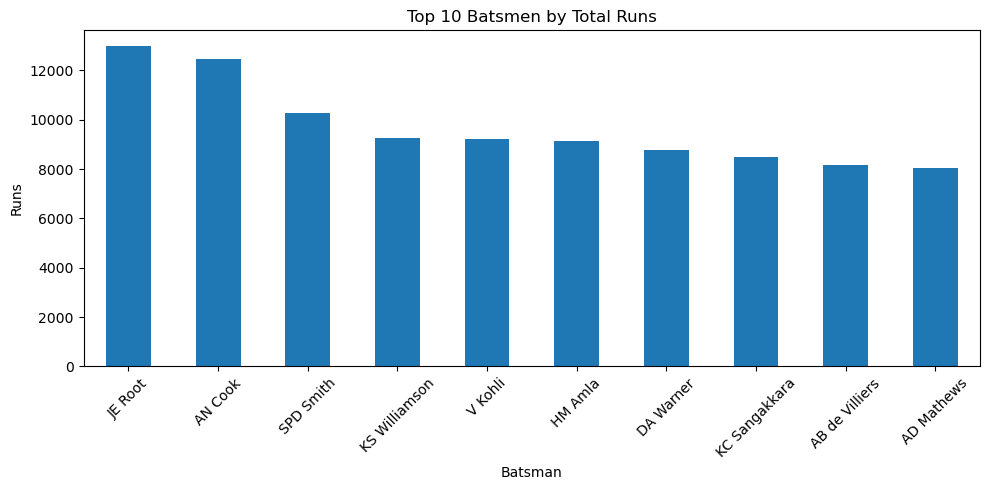

In [4]:
# Top 10 batsmen by total runs
top_batsmen = df.groupby('batsman')['runs_batsman'].sum().sort_values(ascending=False).head(10)
top_batsmen.plot(kind='bar', title='Top 10 Batsmen by Total Runs', figsize=(10, 5))
plt.ylabel("Runs")
plt.xlabel("Batsman")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


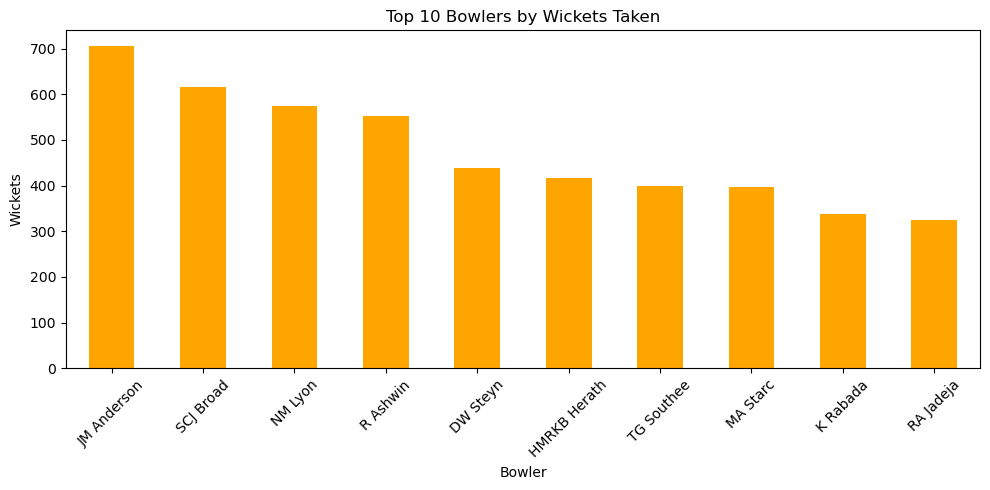

In [5]:
# Top 10 bowlers by wickets
top_bowlers = df[df['wicket'] == 1].groupby('bowler').size().sort_values(ascending=False).head(10)
top_bowlers.plot(kind='bar', title='Top 10 Bowlers by Wickets Taken', figsize=(10, 5), color='orange')
plt.ylabel("Wickets")
plt.xlabel("Bowler")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature Engineering

In [6]:
def calculate_clutch_factor(df):
    df['clutch'] = np.where(df['ball'] > 40, df['runs_batsman'], 0)
    clutch_factor = df['clutch'].sum() / df['runs_batsman'].sum()
    print(f"Clutch Factor: {clutch_factor:.2f}")
    return clutch_factor

In [7]:
def calculate_win_contribution(df):
    df['win_contribution'] = np.where(df['result'] == df['team'], df['runs_batsman'], 0)
    contribution = df['win_contribution'].sum()
    print(f"Total Win Contribution: {contribution}")
    return contribution

In [8]:
def identify_game_changing_innings(df):
    team_runs = df.groupby('team')['runs_total'].sum()
    for team, runs in team_runs.items():
        player_runs = df[df['team'] == team].groupby('batsman')['runs_batsman'].sum()
        game_changers = player_runs[player_runs > 0.3 * runs]
        print(f"Game-Changing Innings for {team}:")
        print(game_changers)

In [9]:
calculate_clutch_factor(df)
calculate_win_contribution(df)
identify_game_changing_innings(df)

Clutch Factor: 0.57
Total Win Contribution: 368843
Game-Changing Innings for Australia:
Series([], Name: runs_batsman, dtype: int64)
Game-Changing Innings for Bangladesh:
Series([], Name: runs_batsman, dtype: int64)
Game-Changing Innings for England:
Series([], Name: runs_batsman, dtype: int64)
Game-Changing Innings for ICC World XI:
Series([], Name: runs_batsman, dtype: int64)
Game-Changing Innings for India:
Series([], Name: runs_batsman, dtype: int64)
Game-Changing Innings for Ireland:
Series([], Name: runs_batsman, dtype: int64)
Game-Changing Innings for New Zealand:
Series([], Name: runs_batsman, dtype: int64)
Game-Changing Innings for Pakistan:
Series([], Name: runs_batsman, dtype: int64)
Game-Changing Innings for South Africa:
Series([], Name: runs_batsman, dtype: int64)
Game-Changing Innings for Sri Lanka:
Series([], Name: runs_batsman, dtype: int64)
Game-Changing Innings for West Indies:
Series([], Name: runs_batsman, dtype: int64)
Game-Changing Innings for Zimbabwe:
Series([]

# Correlation Heatmap

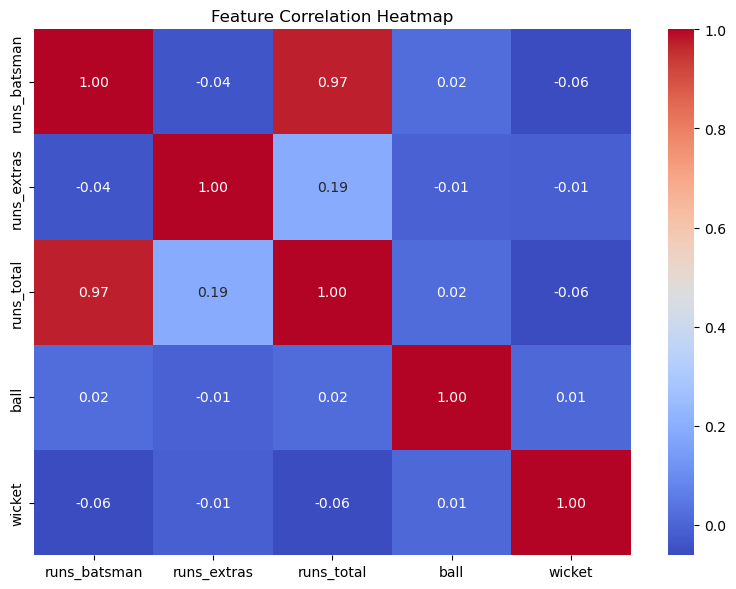

In [10]:
corr = df[['runs_batsman', 'runs_extras', 'runs_total', 'ball', 'wicket']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Prepare Data for Modeling

In [11]:
features = df[['runs_batsman', 'runs_extras', 'runs_total', 'ball', 'wicket']]
label_encoder = LabelEncoder()
df['result_encoded'] = label_encoder.fit_transform(df['result'])
target = df['result_encoded']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Model Training & Evaluation

# Random Forest


Random Forest Accuracy: 0.22179455690211888
              precision    recall  f1-score   support

           0       0.16      0.03      0.06     48759
           1       0.02      0.00      0.00      8151
           2       0.23      0.93      0.37     75616
           3       0.14      0.02      0.04     43287
           4       0.11      0.01      0.02     38868
           5       0.00      0.00      0.00       658
           6       0.07      0.00      0.00     23181
           7       0.06      0.00      0.00     21444
           8       0.11      0.01      0.01     33012
           9       0.10      0.00      0.00     25173
          10       0.04      0.00      0.00     14085
          11       0.00      0.00      0.00      1620

    accuracy                           0.22    333854
   macro avg       0.09      0.08      0.04    333854
weighted avg       0.13      0.22      0.10    333854



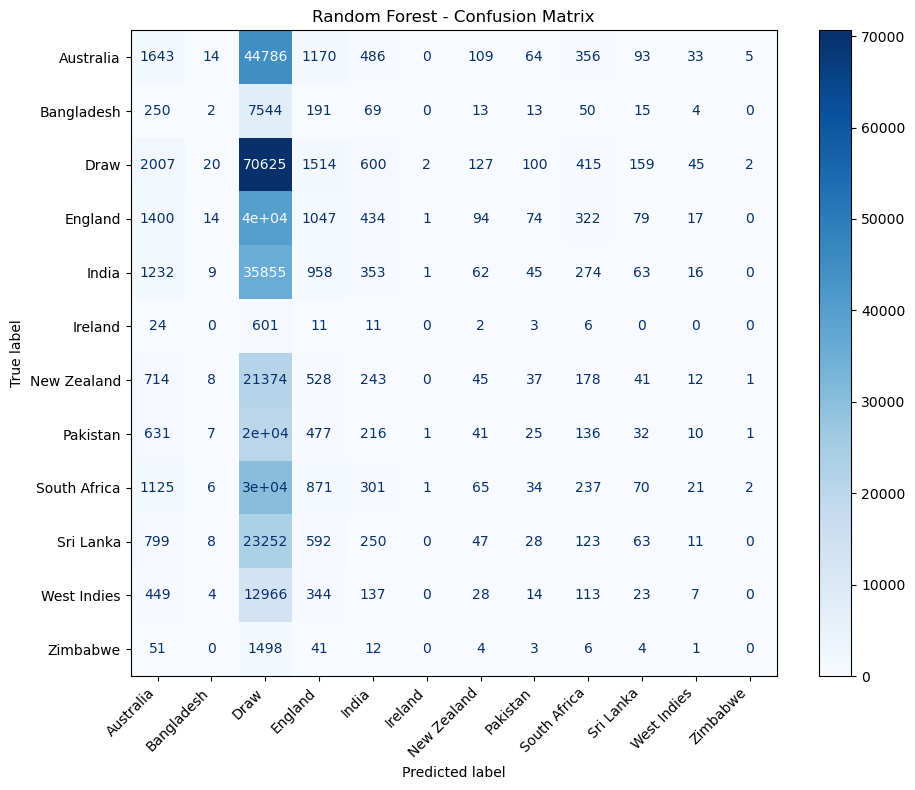

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
cm_rf = confusion_matrix(y_test, rf_preds)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 8))
disp_rf.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.show()

# XGBoost


XGBoost Accuracy: 0.2267188651326628
              precision    recall  f1-score   support

           0       0.18      0.02      0.03     48759
           1       0.00      0.00      0.00      8151
           2       0.23      0.98      0.37     75616
           3       0.15      0.01      0.01     43287
           4       0.15      0.00      0.00     38868
           5       0.00      0.00      0.00       658
           6       0.03      0.00      0.00     23181
           7       0.06      0.00      0.00     21444
           8       0.14      0.00      0.00     33012
           9       0.04      0.00      0.00     25173
          10       0.00      0.00      0.00     14085
          11       0.00      0.00      0.00      1620

    accuracy                           0.23    333854
   macro avg       0.08      0.08      0.04    333854
weighted avg       0.14      0.23      0.09    333854



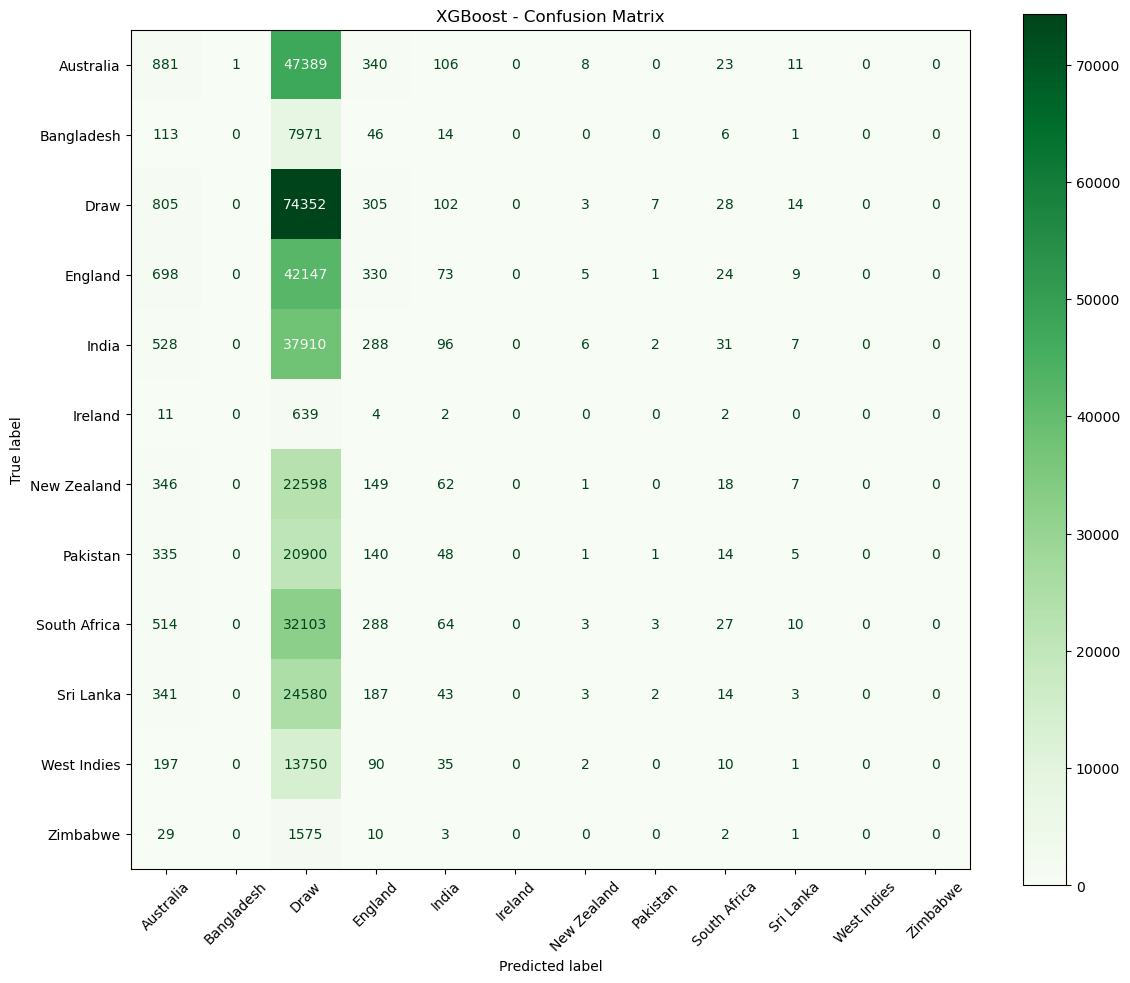

In [13]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("\nXGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds, zero_division=0))
cm_xgb = confusion_matrix(y_test, xgb_preds)
fig, ax = plt.subplots(figsize=(12, 10))
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=label_encoder.classes_)
disp_xgb.plot(cmap='Greens', ax=ax, xticks_rotation=45)
plt.title("XGBoost - Confusion Matrix")
plt.tight_layout()
plt.show()

# Neural Network

In [14]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(y_train_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, verbose=0)
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("\nNeural Network Accuracy:", accuracy)

10433/10433 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.2258 - loss: 2.1688

Neural Network Accuracy: 0.22673983871936798


# SHAP Explainability using TreeExplainer for XGBoost

In [15]:
explainer = shap.TreeExplainer(xgb_model)
X_test_fixed = X_test.copy()
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot for Each Class

In [16]:
# Check shapes first
print("X_test shape:", X_test_fixed.shape)
print("shap_values[0] shape:", shap_values[0].shape)

# Plot SHAP summary for each class safely
for i, class_name in enumerate(label_encoder.classes_):
    print(f"\nSHAP Summary Plot for Class: {class_name}")
    if shap_values[i].shape[0] == X_test_fixed.shape[0]:
        shap.summary_plot(shap_values[i], X_test_fixed, max_display=5, plot_type='bar')
    elif shap_values[i].shape[1] == X_test_fixed.shape[1] + 1:
        shap.summary_plot(shap_values[i][:, :-1], X_test_fixed, max_display=5, plot_type='bar')
    else:
        print(f"⚠️ Skipping class {class_name} due to shape mismatch.")

X_test shape: (333854, 5)
shap_values[0] shape: (5, 12)

SHAP Summary Plot for Class: Australia
⚠️ Skipping class Australia due to shape mismatch.

SHAP Summary Plot for Class: Bangladesh
⚠️ Skipping class Bangladesh due to shape mismatch.

SHAP Summary Plot for Class: Draw
⚠️ Skipping class Draw due to shape mismatch.

SHAP Summary Plot for Class: England
⚠️ Skipping class England due to shape mismatch.

SHAP Summary Plot for Class: India
⚠️ Skipping class India due to shape mismatch.

SHAP Summary Plot for Class: Ireland
⚠️ Skipping class Ireland due to shape mismatch.

SHAP Summary Plot for Class: New Zealand
⚠️ Skipping class New Zealand due to shape mismatch.

SHAP Summary Plot for Class: Pakistan
⚠️ Skipping class Pakistan due to shape mismatch.

SHAP Summary Plot for Class: South Africa
⚠️ Skipping class South Africa due to shape mismatch.

SHAP Summary Plot for Class: Sri Lanka
⚠️ Skipping class Sri Lanka due to shape mismatch.

SHAP Summary Plot for Class: West Indies
⚠️ Skipp

# Final Summary and Comparison

In [17]:
print("\nModel Comparison Summary:")
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds):.2f}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_preds):.2f}")
print(f"Neural Network Accuracy: {accuracy:.2f}")


Model Comparison Summary:
Random Forest Accuracy: 0.22
XGBoost Accuracy: 0.23
Neural Network Accuracy: 0.23


# Bar chart of model comparison

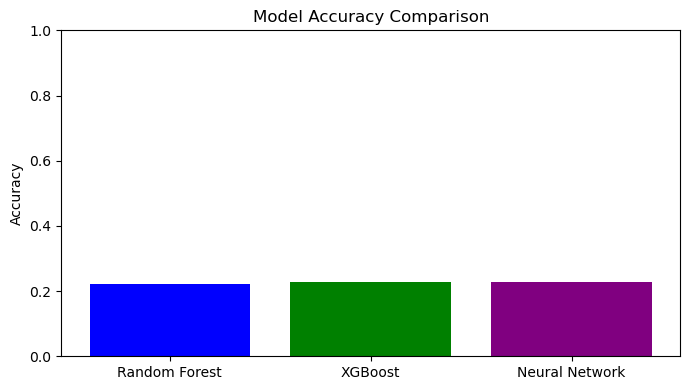

In [18]:
accuracies = {
    'Random Forest': accuracy_score(y_test, rf_preds),
    'XGBoost': accuracy_score(y_test, xgb_preds),
    'Neural Network': accuracy
}

plt.figure(figsize=(7, 4))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'purple'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Average Run Rate by Ball

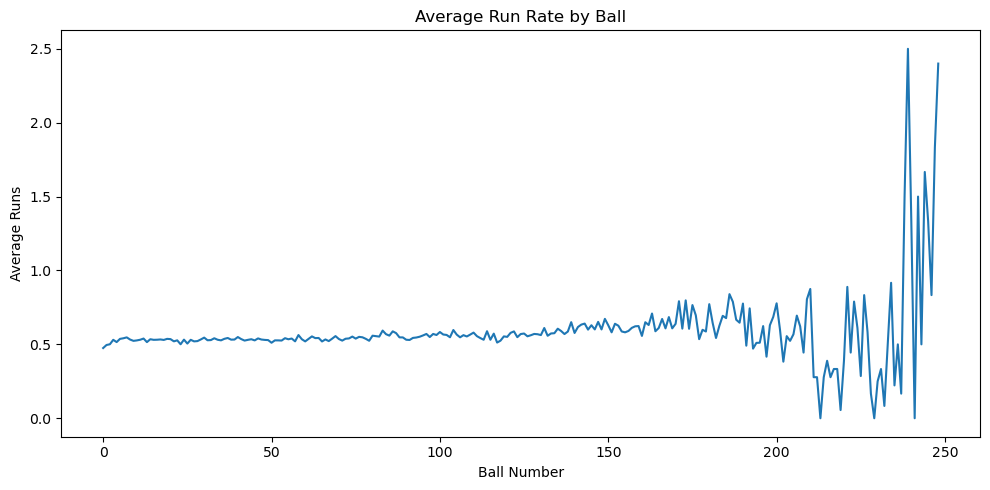

In [19]:
run_rate = df.groupby(df['ball'].astype(int))['runs_total'].mean()
run_rate.plot(title="Average Run Rate by Ball", figsize=(10,5))
plt.xlabel("Ball Number")
plt.ylabel("Average Runs")
plt.tight_layout()
plt.show()

# Wickets by Ball Number

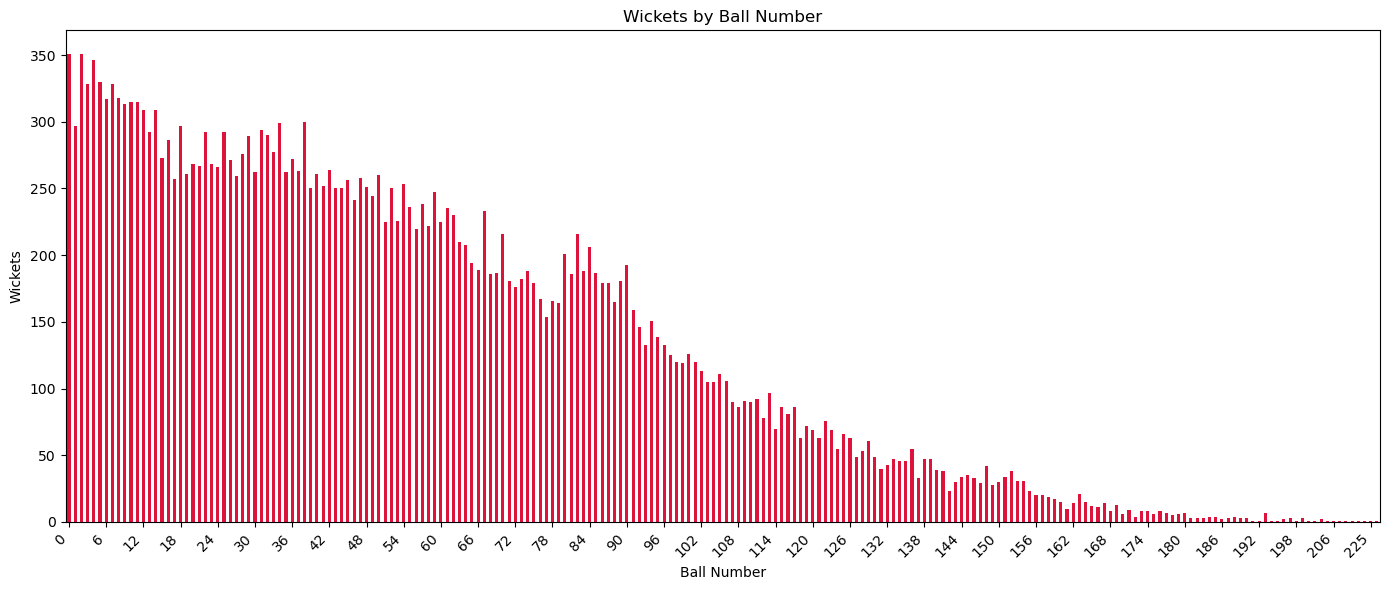

In [20]:
wicket_timeline = df[df['wicket'] == 1].groupby(df['ball'].astype(int)).size()

plt.figure(figsize=(14, 6))
wicket_timeline.plot(kind='bar', title="Wickets by Ball Number", color='crimson')

# Improve x-axis: show fewer ticks and rotate labels
plt.xlabel("Ball Number")
plt.ylabel("Wickets")
plt.xticks(ticks=range(0, len(wicket_timeline), 6),  # Show every 6th ball (i.e., end of an over)
           labels=wicket_timeline.index[::6],        # Label only every 6th ball
           rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Batsman Runs Across Match Phases

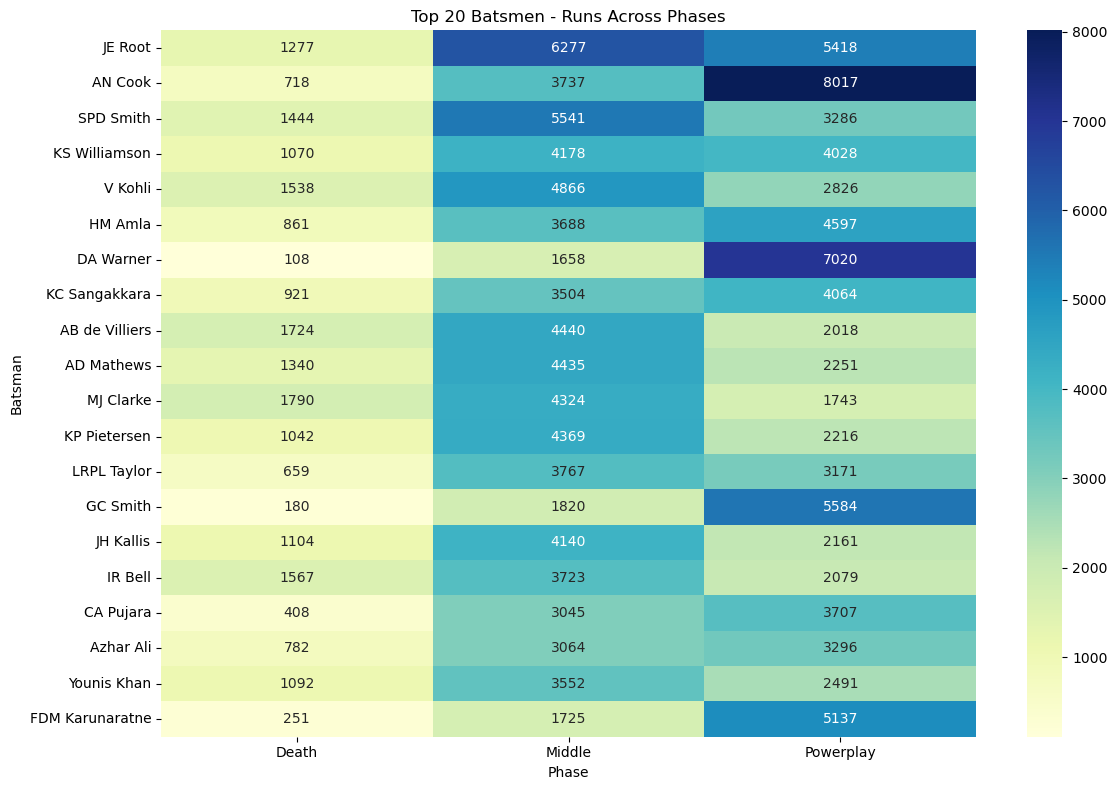

In [21]:
# Add the 'phase' column first
def classify_phase(ball):
    if ball <= 36:
        return 'Powerplay'
    elif ball <= 96:
        return 'Middle'
    else:
        return 'Death'

df['phase'] = df['ball'].apply(classify_phase)

# Now safely group and plot
phase_runs = df.groupby(['batsman', 'phase'])['runs_batsman'].sum().unstack().fillna(0)
top_batsmen = phase_runs.sum(axis=1).sort_values(ascending=False).head(20)
phase_runs_top = phase_runs.loc[top_batsmen.index]

plt.figure(figsize=(12, 8))
sns.heatmap(phase_runs_top, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title("Top 20 Batsmen - Runs Across Phases")
plt.xlabel("Phase")
plt.ylabel("Batsman")
plt.tight_layout()
plt.show()

# Bowler Economy vs Wickets Scatter

In [22]:
# Recreate bowler_stats if it's missing
bowler_stats = df.groupby('bowler').agg({
    'runs_total': 'sum',
    'ball': 'count',
    'wicket': 'sum'
})
bowler_stats['economy'] = bowler_stats['runs_total'] / (bowler_stats['ball'] / 6)

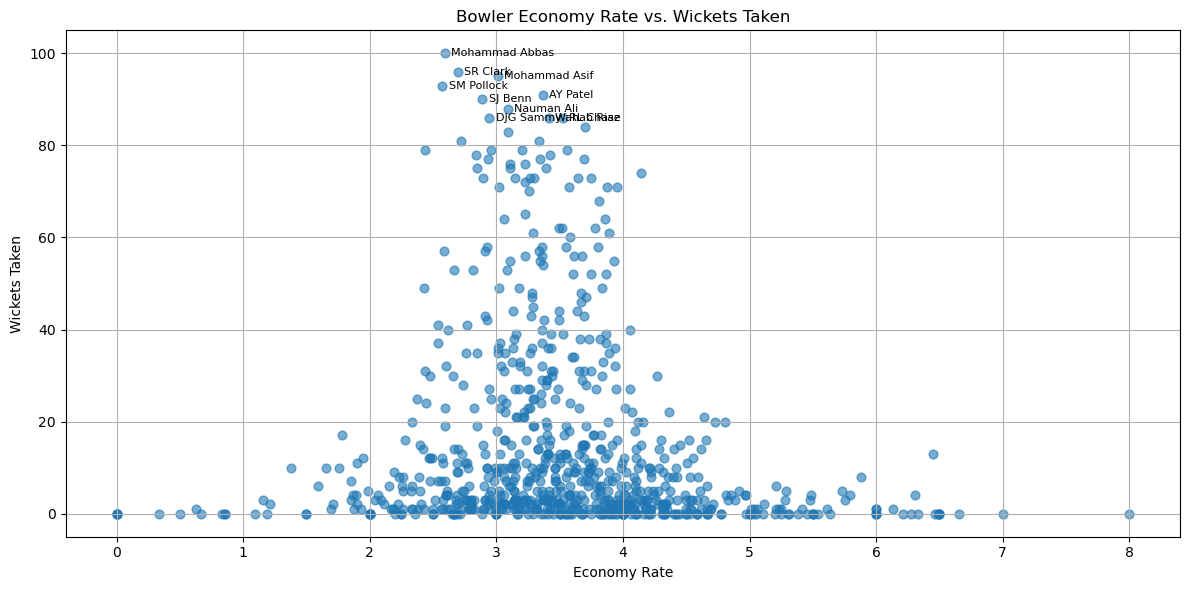

In [23]:
# Filter to reasonable range for clarity
filtered_stats = bowler_stats[(bowler_stats['economy'] <= 8) & (bowler_stats['wicket'] <= 100)]

plt.figure(figsize=(12, 6))
plt.scatter(filtered_stats['economy'], filtered_stats['wicket'], alpha=0.6, s=40)

# Label top 10 wicket takers
top_wicket_takers = filtered_stats.sort_values(by='wicket', ascending=False).head(10)
for name, row in top_wicket_takers.iterrows():
    plt.text(row['economy'] + 0.05, row['wicket'], name, fontsize=8, ha='left', va='center')

plt.title("Bowler Economy Rate vs. Wickets Taken")
plt.xlabel("Economy Rate")
plt.ylabel("Wickets Taken")
plt.grid(True)
plt.tight_layout()
plt.show()

# Top 10 Clutch Players

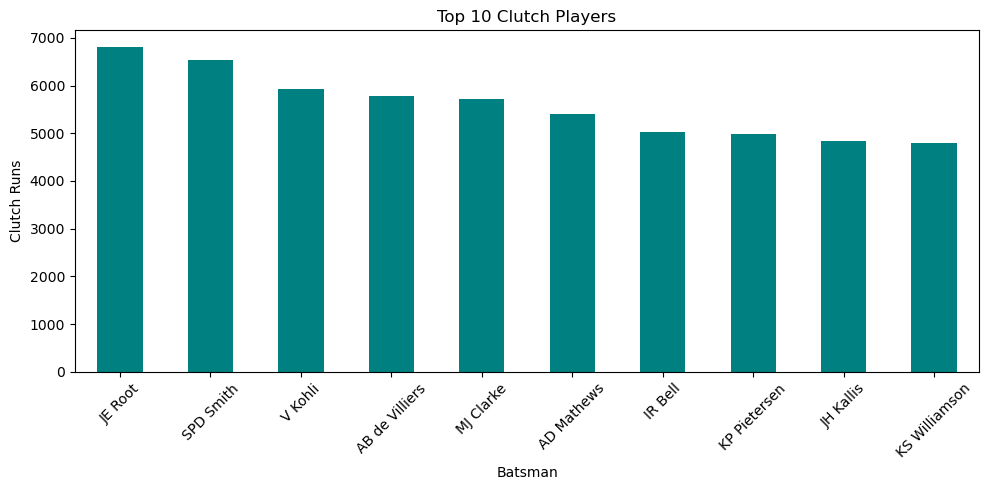

In [24]:
clutch_df = df[df['clutch'] > 0].groupby('batsman')['clutch'].sum().sort_values(ascending=False).head(10)
clutch_df.plot(kind='bar', title='Top 10 Clutch Players', figsize=(10, 5), color='teal')
plt.ylabel("Clutch Runs")
plt.xlabel("Batsman")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 Win Contributors

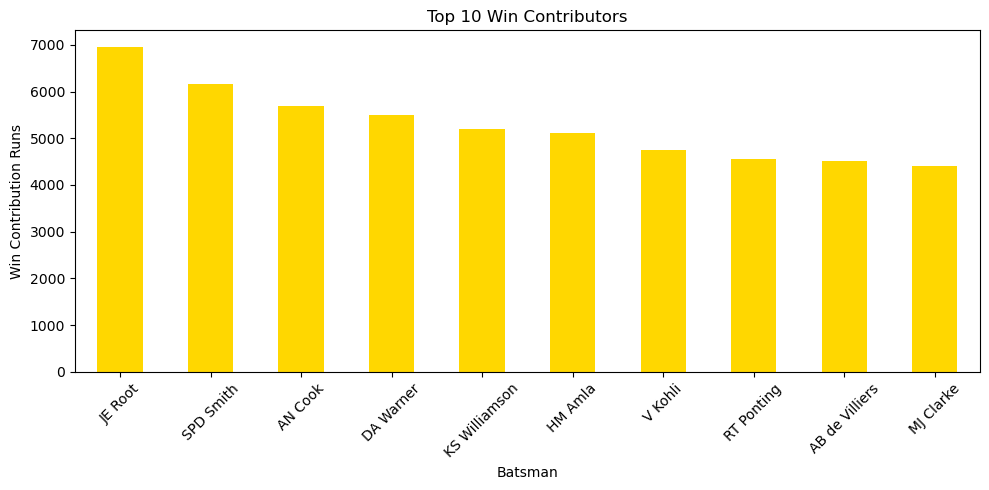

In [25]:
win_contrib_df = df[df['win_contribution'] > 0].groupby('batsman')['win_contribution'].sum().sort_values(ascending=False).head(10)
win_contrib_df.plot(kind='bar', title='Top 10 Win Contributors', figsize=(10, 5), color='gold')
plt.ylabel("Win Contribution Runs")
plt.xlabel("Batsman")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# SHAP Dependence Plot

In [26]:
# Ensure SHAP is reset
explainer = shap.TreeExplainer(xgb_model)

# Recompute SHAP values on full X_test
print("Recomputing SHAP values on full X_test...")
X_test_full = X_test.copy()  # optional: prevent mutation
shap_values = explainer.shap_values(X_test_full)

# Confirm shape match
print("X_test shape:", X_test_full.shape)
print("shap_values[0] shape:", shap_values[0].shape)

# Only plot if shapes match
if shap_values[0].shape[0] == X_test_full.shape[0]:
    shap.dependence_plot('ball', shap_values[0], X_test_full)
else:
    print("SHAP and X_test row counts do not match! Check if you used .head() earlier.")


Recomputing SHAP values on full X_test...
X_test shape: (333854, 5)
shap_values[0] shape: (5, 12)
SHAP and X_test row counts do not match! Check if you used .head() earlier.


# Match Result Distribution

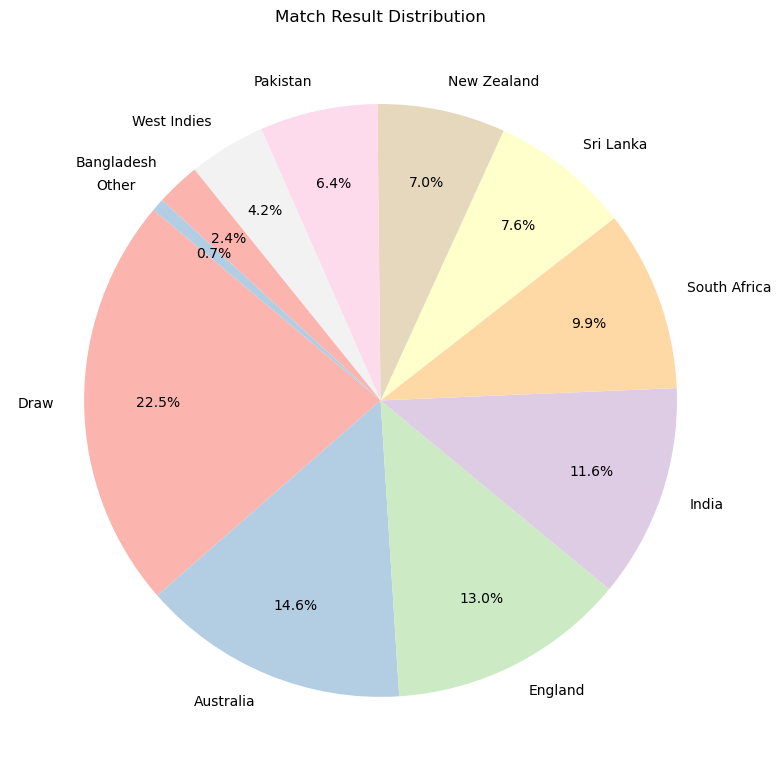

In [33]:
# Count match results
result_counts = df['result'].value_counts()

# Threshold: % of total to be considered "small"
threshold = 0.02 * result_counts.sum()

# Separate large and small categories
large = result_counts[result_counts > threshold]
small = result_counts[result_counts <= threshold]

# Combine small into "Other"
if not small.empty:
    large['Other'] = small.sum()

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    large,
    labels=large.index,
    autopct='%1.1f%%',
    startangle=140,
    labeldistance=1.1,
    pctdistance=0.75,
    colors=plt.cm.Pastel1.colors
)

plt.title("Match Result Distribution")
plt.tight_layout()
plt.show()

# Batsman vs Bowler Heatmap

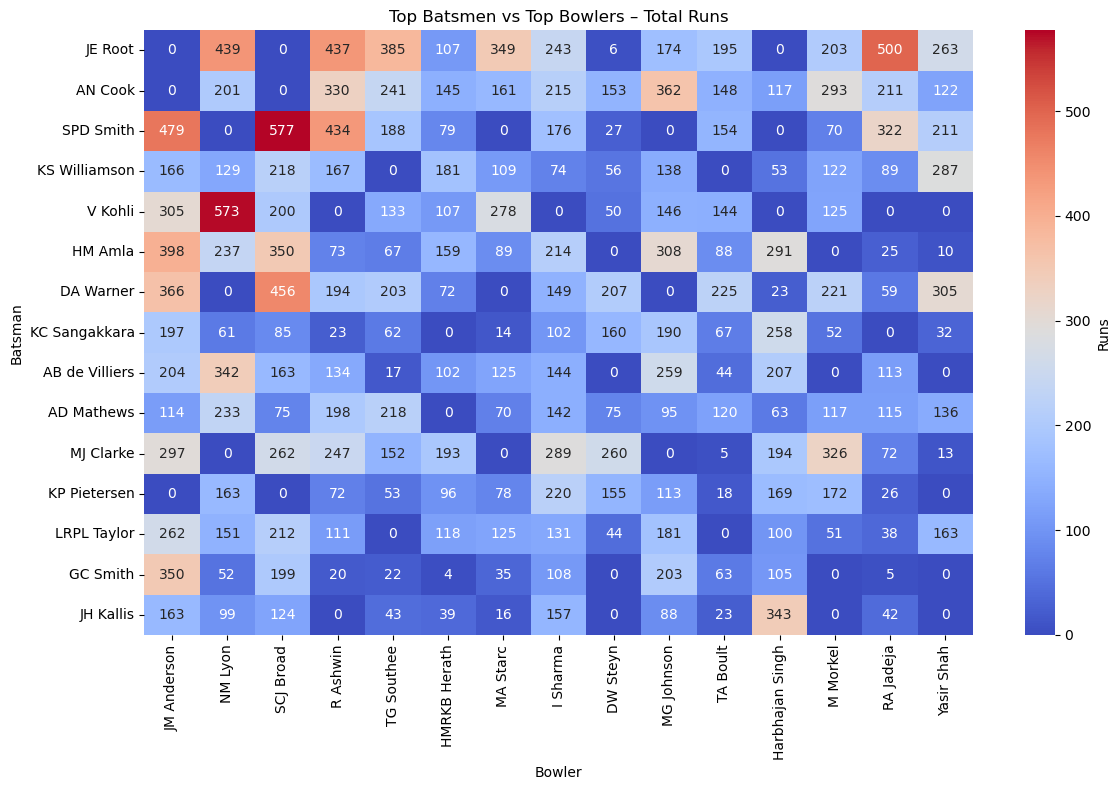

In [34]:
# Create batsman vs bowler pivot table (example)
pivot = df.pivot_table(index='batsman', columns='bowler', values='runs_batsman', aggfunc='sum').fillna(0)

# Filter: Top 15 batsmen and bowlers based on total runs
top_batsmen = pivot.sum(axis=1).sort_values(ascending=False).head(15).index
top_bowlers = pivot.sum(axis=0).sort_values(ascending=False).head(15).index
filtered_pivot = pivot.loc[top_batsmen, top_bowlers]

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_pivot, cmap="coolwarm", annot=True, fmt=".0f", cbar_kws={'label': 'Runs'})
plt.title("Top Batsmen vs Top Bowlers – Total Runs")
plt.xlabel("Bowler")
plt.ylabel("Batsman")
plt.tight_layout()
plt.show()

# Save Data and Model for Dashboard

In [35]:
# Save cleaned dataset
df.to_csv("your_cleaned_ppi_data.csv", index=False)

# Save model
joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']